# Predicción de anomalías, en el sector industrial

 __Nombre:__ Adonis González

## 1. Inicialización y carga de utilidades

In [1]:
import sys  
sys.path.insert(0, '../src/')

from imports import *
from plot_functions import * 
from model_functions import *
from data_functions import *
from metric_fuctions import *

## 2. Preprocesado necesario para regressors

In [2]:
# paths 
ROOT_DIR = os.path.abspath("../")
data_dir = os.path.join(ROOT_DIR, "data")
data_1 = os.path.join(data_dir, "1")
train = os.path.join(data_1, "PM_train.csv")
test = os.path.join(data_1, "PM_test.csv")
gtruth = os.path.join(data_1, "PM_truth.csv")

sensores = ["measure_" + str(i) for i in range(1, 22)]
col_names=["id", "cycle_time", "op_sett_1", "op_sett_2", "op_sett_3"] + sensores
print(col_names)

# cargamos datos como dataframes
df_train = pd.read_csv(train, sep=";", header=None)
df_test = pd.read_csv(test, sep=";", header=None)
df_truth = pd.read_csv(gtruth, sep=";", header=None)

df_train.columns = col_names
df_test.columns = col_names


check_df_null(df_train)
check_df_null(df_test)

df_train.drop(columns=['op_sett_3',
                       'measure_1',
                       'measure_5',
                       'measure_10',
                       'measure_16',
                       'measure_18',
                       'measure_19'],inplace=True)

df = prepare_train_data(df_train)

id_col = pd.DataFrame(df["id"])

train_df = df.drop(columns = ['id','op_sett_1','op_sett_2','measure_6', 'measure_14'])


df_test.drop(columns=['measure_18',
                      'measure_19',
                      'measure_5',
                      'measure_1',
                      'op_sett_3',
                      'measure_16',
                      'measure_10',
                      'op_sett_1',
                      'op_sett_2',
                      'measure_6',
                      'measure_14'
                     ],inplace=True)


test_max = df_test.groupby('id')['cycle_time'].max().reset_index()
test_max.columns = ['id','max']
df_test = df_test.merge(test_max, on=['id'], how='left')
test = df_test[df_test['cycle_time'] == df_test['max']].reset_index()


test.drop(columns=['index',
                   'max',
                   'id'
                   ], inplace=True)


# y_true, variable con los ground truth en forma numpy
y_true = df_truth[0].to_numpy()
# test en forma numpy
X_001_test = test.to_numpy()

['id', 'cycle_time', 'op_sett_1', 'op_sett_2', 'op_sett_3', 'measure_1', 'measure_2', 'measure_3', 'measure_4', 'measure_5', 'measure_6', 'measure_7', 'measure_8', 'measure_9', 'measure_10', 'measure_11', 'measure_12', 'measure_13', 'measure_14', 'measure_15', 'measure_16', 'measure_17', 'measure_18', 'measure_19', 'measure_20', 'measure_21']


## 3. Algoritmos Clasificaores

Algoritmos clasificadores

In [3]:
# Se crea la variable time-to-failure
# Cuando tengamos 10 ciclos o menos, 
# el motor tiene más probalidad de fallar.
TTF = 10
train_df['label'] = np.where(train_df['RUL'] <= TTF, 1, 0 )

In [4]:
train_df.head()

,cycle_time,measure_2,measure_3,measure_4,measure_7,measure_8,measure_9,measure_11,measure_12,measure_13,measure_15,measure_17,measure_20,measure_21,RUL,label
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,84.195,392,39.06,234.190,191,0
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,84.318,392,39.00,234.236,190,0
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,84.178,390,38.95,233.442,189,0
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,83.682,392,38.88,233.739,188,0
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,84.294,393,38.90,234.044,187,0


Text(0.5, 1.0, 'Scatter patter measure_9 or measure_7')

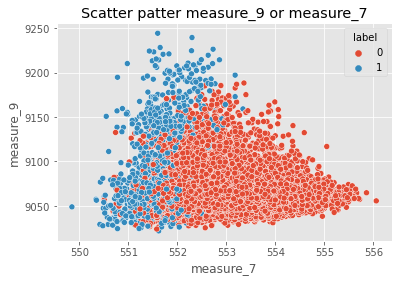

In [5]:
sns.scatterplot(x="measure_7", y="measure_9", hue="label", data=train_df)
plt.title('Scatter patter measure_9 or measure_7')

Text(0.5, 1.0, 'Scatter patter measure_4 or measure_9')

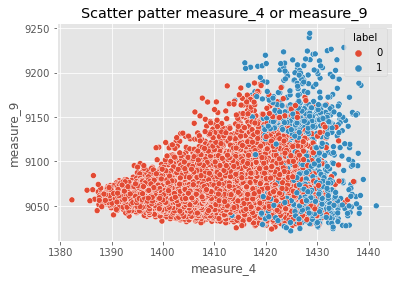

In [6]:
sns.scatterplot(x="measure_4", y="measure_9", hue="label", data=train_df)
plt.title('Scatter patter measure_4 or measure_9')

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

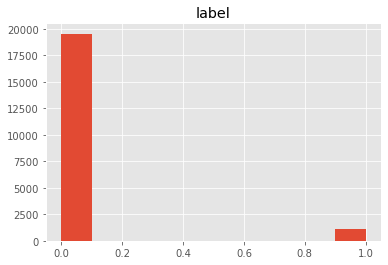

In [28]:
# balance de clase target en clasificación
train_df.iloc[:,15:].hist()

In [7]:
# exclude the RUL property and form an array of attributes and the target variable
X_class = train_df.iloc[:,:14].to_numpy() 
Y_class = train_df.iloc[:,15:].to_numpy()
Y_class = np.ravel(Y_class)

In [8]:
# Class balancing to improve classifier performance
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_class, Y_class)
X_resampled, y_resampled = ros.fit_resample (X_class, Y_class)
print('The number of elements before the operation:', len(X_class))
print('The number of elements after the operation:', len(X_resampled))

The number of elements before the operation: 20631
The number of elements after the operation: 39062


In [30]:
len(y_resampled)

39062

In [10]:
X_train,X_test,y_train,y_test = train_test_split(
                            X_resampled,
                            y_resampled,
                            test_size = 0.2,
                            random_state = 123)

In [11]:
y_true_class = np.where(y_true <= TTF, 1, 0 )

### 3.1 Decision Tree

Profundidad del árbol: 8
Número de nodos terminales: 71


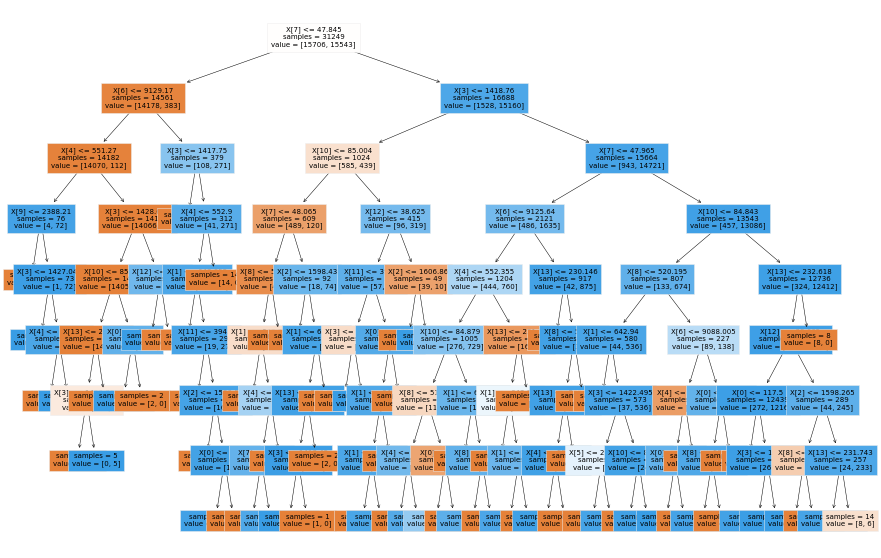

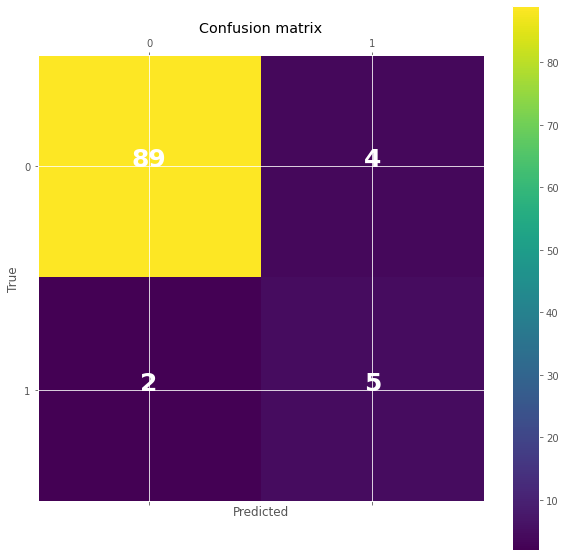

,precision,recall,f1-score,support
0,0.98,0.96,0.97,93.00
1,0.56,0.71,0.63,7.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.77,0.84,0.80,100.00
weighted avg,0.95,0.94,0.94,100.00


In [12]:
# Creación del modelo
model_dt = DecisionTreeClassifier(max_depth = 8, 
                                criterion = 'gini', 
                                random_state = 0)

model_dt.fit(X_train,y_train)

y_dt_pred  =model_dt.predict(X_001_test)

# Estructura del árbol creado
fig, ax = plt.subplots(figsize=(15, 10))
# plt.style.use('classic')
print(f"Profundidad del árbol: {model_dt.get_depth()}")
print(f"Número de nodos terminales: {model_dt.get_n_leaves()}")

plot = plot_tree(
            decision_tree = model_dt,
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

# Results
cm = confusion_matrix(y_true_class, y_dt_pred)
plot_cm(cm, [0,1])

pd.options.display.float_format = "{:,.2f}".format
clsf_report = pd.DataFrame(classification_report(y_true_class, y_dt_pred, output_dict=True)).transpose()
clsf_report

### prunning

Mejor ccp_alpha {'ccp_alpha': 0.0}
Profundidad del árbol: 42
Número de nodos terminales: 367


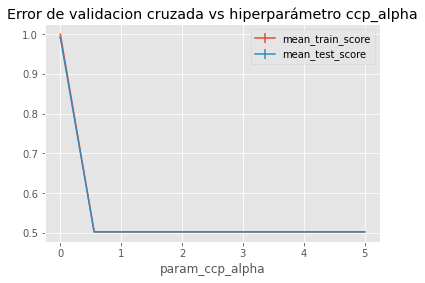

In [13]:
from sklearn.model_selection import GridSearchCV
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 0
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train,y_train)

fig, ax = plt.subplots()
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

# Mejor valor ccp_alpha encontrado
print("Mejor ccp_alpha " +  str(grid.best_params_))

# Estructura del árbol final
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

In [14]:
predicciones = modelo_final.predict(X = X_001_test)

accuracy = accuracy_score(
            y_true    = y_true_class,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 93.0 %


### 3.2 Random Forest

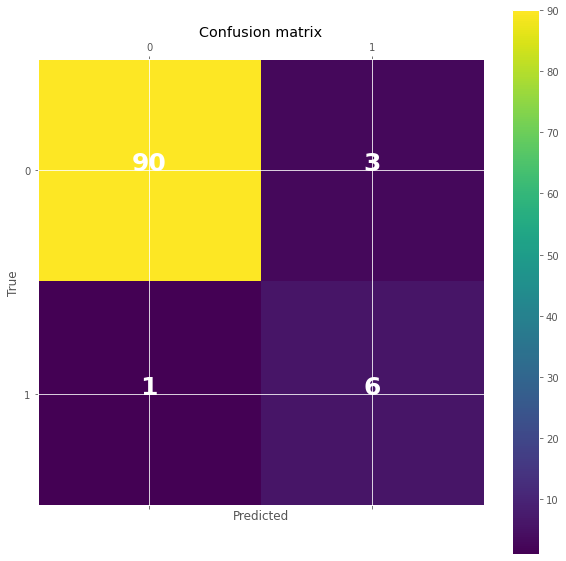

,precision,recall,f1-score,support
0,0.99,0.97,0.98,93.00
1,0.67,0.86,0.75,7.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.83,0.91,0.86,100.00
weighted avg,0.97,0.96,0.96,100.00


In [15]:
forest = RandomForestClassifier(n_estimators=70,
                                max_depth = 8, 
                                random_state=123)
forest.fit(X_train,y_train)

y_rf_pred  =forest.predict(X_001_test)

# Results
cm = confusion_matrix(y_true_class, y_rf_pred)
plot_cm(cm, [0,1])

clsf_report = pd.DataFrame(classification_report(y_true_class, y_rf_pred, output_dict=True)).transpose()
clsf_report



# PREDICCIONES EN EL CONJUNTO DE VALIDACION
# forest = RandomForestClassifier(n_estimators=70,
#                                 max_depth = 8, 
#                                 random_state=193)
# forest.fit(X_train,y_train)

# y_rf_pred  =forest.predict(X_test)

# # Results
# cm = confusion_matrix(y_test, y_rf_pred)
# plot_cm(cm, [0,1])

# clsf_report = pd.DataFrame(classification_report(y_test, y_rf_pred, output_dict=True)).transpose()
# clsf_report

### 3.3 XGBClassifier

B:\software\miniConda\envs\models\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


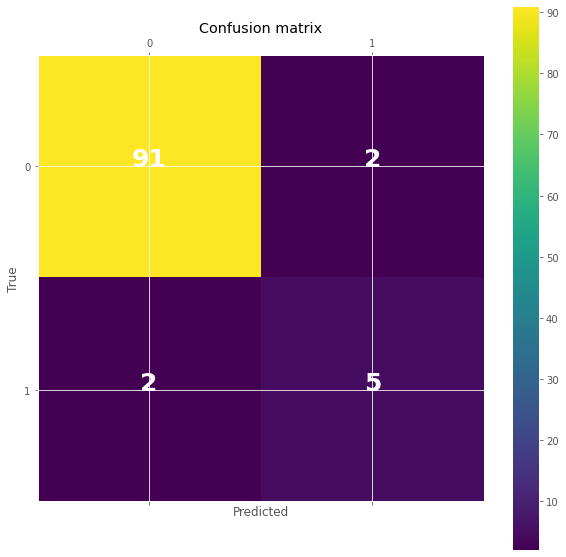

,precision,recall,f1-score,support
0,0.98,0.98,0.98,93.00
1,0.71,0.71,0.71,7.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.85,0.85,0.85,100.00
weighted avg,0.96,0.96,0.96,100.00


In [16]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

y_xgb_pred = model_xgb.predict(X_001_test)

# Results
cm = confusion_matrix(y_true_class, y_xgb_pred)
plot_cm(cm, [0,1])

clsf_report = pd.DataFrame(classification_report(y_true_class, y_xgb_pred, output_dict=True)).transpose()
clsf_report

## 4. Evaluación y comparación modelos

In [17]:
predicted = pd.DataFrame()
predicted['DT'] = y_dt_pred
predicted ['RF'] =  y_rf_pred
predicted['XGB'] = y_xgb_pred

predicted['RUL']= df_truth[0]
predicted['true_label'] = y_true_class
predicted['id'] = predicted.index + 1

In [18]:
predicted[predicted['true_label'] == 1]

,DT,RF,XGB,RUL,true_label,id
30,0,1,1,8,1,31
33,1,1,1,7,1,34
41,0,0,0,10,1,42
67,1,1,0,8,1,68
75,1,1,1,10,1,76
80,1,1,1,8,1,81
81,1,1,1,9,1,82


In [19]:
predicted[predicted['true_label'] != predicted['DT']]

,DT,RF,XGB,RUL,true_label,id
30,0,1,1,8,1,31
34,1,1,1,11,0,35
41,0,0,0,10,1,42
48,1,1,0,21,0,49
55,1,1,1,15,0,56
91,1,0,0,20,0,92


In [20]:
predicted[predicted['true_label'] != predicted['RF']]

,DT,RF,XGB,RUL,true_label,id
34,1,1,1,11,0,35
41,0,0,0,10,1,42
48,1,1,0,21,0,49
55,1,1,1,15,0,56


In [21]:
predicted[predicted['true_label'] != predicted['XGB']]

,DT,RF,XGB,RUL,true_label,id
34,1,1,1,11,0,35
41,0,0,0,10,1,42
55,1,1,1,15,0,56
67,1,1,0,8,1,68


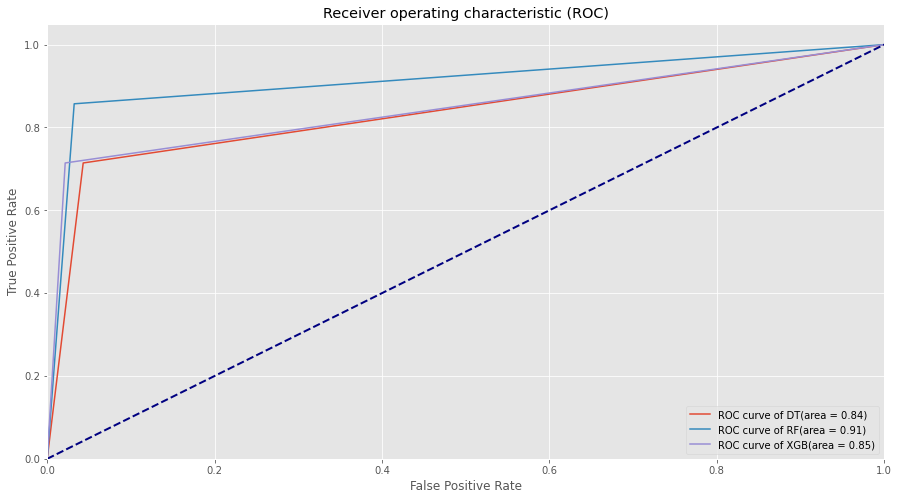

In [22]:
fpt_DT, tpr_DT, _ = metrics.roc_curve(y_true_class,  y_dt_pred)
fpr_RF, tpr_RF, _ = metrics.roc_curve(y_true_class,  y_rf_pred)
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_true_class,  y_xgb_pred)                      

auc_DT = metrics.auc(fpt_DT,  tpr_DT)
auc_RF = metrics.auc(fpr_RF,  tpr_RF)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)


plt.figure(figsize=(15, 8))

plt.plot(fpt_DT,tpr_DT, label='ROC curve of DT(area = %0.2f)' % auc_DT)
plt.plot(fpr_RF,tpr_RF, label='ROC curve of RF(area = %0.2f)' % auc_RF)
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of XGB(area = %0.2f)' % auc_xgb)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()